# From Linear Regression to Gaussian Processes

In this notebook we look at the path from linear regression to gaussian processes as outlined in [chapter 2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf) of [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/).

For a few examples about linear regression and its relationship to bayesian methods have a look at the following [notebook](https://nbviewer.jupyter.org/github/cs224/dev-meetup-bayesian-methods-for-hackers/blob/master/bayesian-methods-for-hackers.ipynb).

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

import sympy
sympy.init_printing()

from sklearn.linear_model import LinearRegression

SEED = 42
np.random.seed(SEED)
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

Let's star by creating some `xpty` and `ypts` that will serve as the example data that we want to treat via our regression procedure.

In [2]:
xpts = np.arange(-2.0, 5.0, 0.5)
xpts

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5])

The function we use to generate the `ypts` is a polynomial of 4th degree:

In [3]:
def myfn(x):
    return (x+1)*(x-2)*(x-2.5)*(x-4)

symx = sympy.symbols('x')
sympy.expand((symx+1)*(symx-2)*(symx-2.5)*(symx-4))

In [4]:
vmyfn = np.vectorize(myfn)

ypts = vmyfn(xpts)
ypts

array([ 108.   ,   38.5  ,   -0.   ,  -16.875,  -20.   ,  -15.75 ,   -9.   ,   -3.125,    0.   ,   -0.   ,   -2.   ,   -3.375,    0.   ,   13.75 ])

## The standard linear model

$$\newcommand{gpvec}[1]{{\bf #1}}$$
We have a training set $\mathcal{D}$ of $n$ observations, $\mathcal{D}=\{(\gpvec{x_i}, y_i) |\; i = 1, ..., n\}$, where $\gpvec{x}$ denotes an input vector (covariates) of dimension D and $y$ denotes a scalar output or target (dependent variable); the column vector inputs for all $n$ cases are aggregated in the D × $n$ design matrix $X$, and the targets are collected in the vector $\gpvec{y}$, so we can write $\mathcal{D}= (X, \gpvec{y})$.

$$f(\gpvec{x})=\gpvec{x}^T\cdot\gpvec{w},\qquad y=f(\gpvec{x})+\epsilon$$
$$\epsilon=\mathcal{N}(0, \sigma_n^2)$$

The standard linear regression formula for predicting $y=f_*$ for a given new $x_*$ is given by:

$$p(f_*|x_*, X, y) = \mathcal{N}\left(\frac{1}{\sigma_n^2}\gpvec{x_*}^TA^{-1}X\gpvec{y},\; \gpvec{x_*}^TA^{-1}\gpvec{x_*}\right)$$
$$A=\frac{1}{\sigma_n^2}XX^T+\Sigma_p^{-1}$$

In case that we set $\Sigma_p=0$ we arrive at the standard equation for linear regression:
$$\bar{\gpvec{w}}=(XX^T)^{-1}X\gpvec{y}$$

Let's perform the standard linear regression via the scikit-learn `LinearRegression` method:

In [5]:
lr = LinearRegression()
X = xpts[:, np.newaxis]
lr.fit(X, ypts)
lr.coef_.squeeze()
lr.intercept_, lr.coef_[0]

If we plot the result the fit is obviously less than optimal:

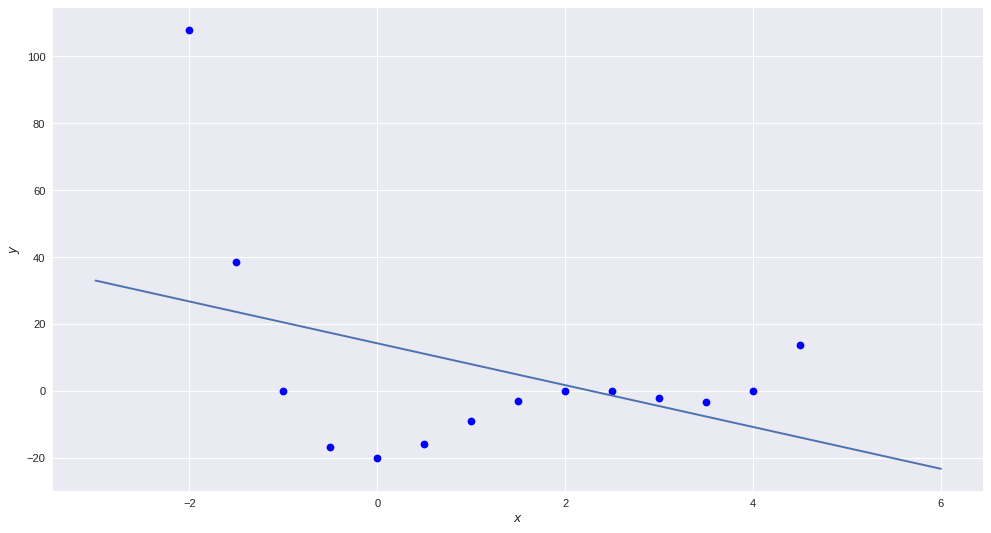

In [6]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.plot(xpts, ypts, 'bo')
plot_x = np.linspace(-3, 6, 100)
ax.plot(plot_x, lr.intercept_ + lr.coef_[0]*plot_x)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

## Projections of inputs into feature space

What would happen if we do not only use the raw $x$ values as the design matrix $X$, but would add artificial or derived covariates to generate a design matrix $\Phi$ with dimensions D${}^*$ × $n$, with D${}^*$ > D. The process by which we create the artificial derived features is a function that we call $\phi(x)$. Obvisouly then also the new weight vector $\gpvec{w}$ has then D${}^*$ elements and not only D elements.

$$\phi(x)=(1, x, x^2, x^3, ...)^T$$
$$f(\gpvec{x})=\phi(\gpvec{x})^T\cdot\gpvec{w}$$

The analysis for this model is analogous to the standard linear model, except that everywhere $\Phi=\Phi(X)$ is
substituted for $X$.

$$p(f_*|x_*, X, y) = \mathcal{N}\left(\frac{1}{\sigma_n^2}\phi(\gpvec{x_*})^TA^{-1}\Phi\gpvec{y},\; \phi(\gpvec{x_*})^TA^{-1}\phi(\gpvec{x_*})\right)$$
with $\Phi=\Phi(X)$ and $A=\sigma_n^{-2}\Phi\Phi^T+\Sigma_p^{-1}$. $A$ and $\Sigma_p$ are D${}^*$×D${}^*$ matrices.

In cases where we have many features (and indeed perhaps even infinitely many), where D${}^*$>$N$ (the number of features is larger than the number of training cases (the design matrix $X$ is taller than broad)) we might prefer to work with the $K$ matrix as defined in the next section. 

Let's define $K=\Phi^T\Sigma_p\Phi$ and let's start with the following identity:

$$\sigma_n^{-2}\Phi(K+\sigma_n^2I)=\sigma_n^{-2}\Phi(\Phi^T\Sigma_p\Phi+\sigma_n^2I)=\sigma_n^{-2}\Phi\Phi^T\Sigma_p\Phi+\Phi=(A-\Sigma_p^{-1})\Sigma_p\Phi+\Phi=A\Sigma_p\Phi$$

Now multiplying by $A^{-1}$ from the left and $(K+\sigma_n^2I)^{-1}$ from the right gives:

$$A^{-1}\sigma_n^{-2}\Phi(K+\sigma_n^2I)(K+\sigma_n^2I)^{-1}=A^{-1}A\Sigma_p\Phi(K+\sigma_n^2I)^{-1}$$

$$\sigma_n^{-2}A^{-1}\Phi=\Sigma_p\Phi(K+\sigma_n^2I)^{-1}$$

Now using this in the above expression for $p(f_*|x_*, X, y)$ we arrive at:

$$p(f_*|x_*, X, y) = \mathcal{N}\left(\phi(\gpvec{x_*})^T\Sigma_p\Phi(K+\sigma_n^2I)^{-1}\gpvec{y},\; ...\right)$$

Notice that in this equation the feature space always enters in the form of $\Phi^T\Sigma_p\Phi$, $\phi(\gpvec{x_*})^T\Sigma_p\Phi$ or $\phi(\gpvec{x_*})^T\Sigma_p\phi(\gpvec{x_*})$; thus the entries of these matrices are invariably of the form $\phi(\gpvec{x})^T\Sigma_p\phi(\gpvec{x'})$, where $\gpvec{x}$ and $\gpvec{x'}$ are in either the training or the test sets.

Let us define $k(\gpvec{x}, \gpvec{x'})=\phi(\gpvec{x})^T\Sigma_p\phi(\gpvec{x'})$. We call $k(\cdot, \cdot)$ a **covariance function or a kernel**. Then defining $\psi(\gpvec{x}) = \Sigma_p^{1/2}\phi(\gpvec{x})$ we obtain a simple dot product representation $k(\gpvec{x}, \gpvec{x'})=\psi(\gpvec{x})\cdot\psi(\gpvec{x'})$.

If an algorithm is defined solely in terms of inner products in input space then it can be lifted into feature space by replacing occurrences of those inner products by $k(\gpvec{x}, \gpvec{x'})$. **This is sometimes called the kernel trick**. This technique is particularly valuable in situations where it is more convenient to compute the kernel than the feature vectors themselves. This may be the case if the feature vector has infinitely many dimensions, e.g. like for the fourier transformation or a taylor series expansion or similar.

The above is the so called **"weight-space view"**. There is an equivalent view that is called the "function-space view". For details have a look at [chapter 2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf) of [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/).

Both kernel ridge regression (KRR) and Gaussian process regression (GPR) learn a target function by employing internally the "kernel trick". A major difference is that **GPR can choose the kernel's hyperparameters based on gradient-ascent on the marginal likelihood function** (and is therefore much faster) while KRR needs to perform a grid search on a cross-validated loss function (mean-squared error loss). A further difference is that GPR learns a generative, probabilistic model of the target function and **can thus provide meaningful confidence intervals** and **posterior samples** along with the predictions while KRR only provides predictions.

Have a look [here](http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html) for details.

### Worked Example

Let's create the matrix $\Phi$ by extending our original input to the linear regression via the features, the powers of the polynomial:

In [7]:
X_poly = np.hstack([X, X**2, X**3, X**4])
X_poly

array([[ -2.00000000e+00,   4.00000000e+00,  -8.00000000e+00,   1.60000000e+01],
       [ -1.50000000e+00,   2.25000000e+00,  -3.37500000e+00,   5.06250000e+00],
       [ -1.00000000e+00,   1.00000000e+00,  -1.00000000e+00,   1.00000000e+00],
       [ -5.00000000e-01,   2.50000000e-01,  -1.25000000e-01,   6.25000000e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.00000000e-01,   2.50000000e-01,   1.25000000e-01,   6.25000000e-02],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.50000000e+00,   2.25000000e+00,   3.37500000e+00,   5.06250000e+00],
       [  2.00000000e+00,   4.00000000e+00,   8.00000000e+00,   1.60000000e+01],
       [  2.50000000e+00,   6.25000000e+00,   1.56250000e+01,   3.90625000e+01],
       [  3.00000000e+00,   9.00000000e+00,   2.70000000e+01,   8.10000000e+01],
       [  3.50000000e+00,   1.22500000e+01,   4.28750000e+01,   1.50062500e+02],
       [  4.00000000e+00,   

And now we perform the exact same linear regression as we did above, but only with the extended design matrix including the features:

In [8]:
lr_poly = LinearRegression()
lr_poly.fit(X_poly, ypts)
lr_poly.intercept_, lr_poly.coef_

(-20.000000000000085, array([  3. ,  14.5,  -7.5,   1. ]))

As you can see this linear regression recovers all of the "weights" of the polynomial of 4th degree that we used to generate the data:

In [9]:
sympy.expand((symx+1)*(symx-2)*(symx-2.5)*(symx-4))

And now we can plot the recovered polynomial:

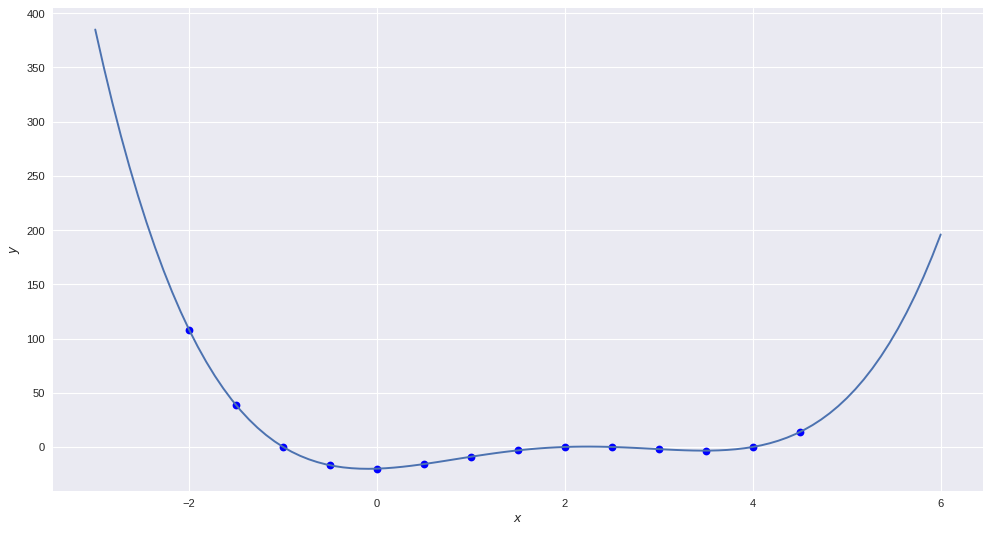

In [10]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.plot(xpts, ypts, 'bo')
plot_x = np.linspace(-3, 6, 100)
ax.plot(plot_x, lr_poly.intercept_ + lr_poly.coef_[0]*plot_x + lr_poly.coef_[1]*plot_x**2 + 
        lr_poly.coef_[2]*plot_x**3 + lr_poly.coef_[3]*plot_x**4)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')